## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import matthews_corrcoef, plot_confusion_matrix,accuracy_score,plot_roc_curve,auc, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from ipywidgets import IntSlider, interact

## Read in Dataset

In [22]:
# Train data
train = pd.read_csv('train.csv')
train.columns = train.columns.str.lower()    # Convert all heading to lower
train['date'] = pd.to_datetime(train['date'])    # Convert date to datetime
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   address                 10506 non-null  object        
 2   species                 10506 non-null  object        
 3   block                   10506 non-null  int64         
 4   street                  10506 non-null  object        
 5   trap                    10506 non-null  object        
 6   addressnumberandstreet  10506 non-null  object        
 7   latitude                10506 non-null  float64       
 8   longitude               10506 non-null  float64       
 9   addressaccuracy         10506 non-null  int64         
 10  nummosquitos            10506 non-null  int64         
 11  wnvpresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [22]:
# Spray data
spray = pd.read_csv('spray.csv')
spray.columns = spray.columns.str.lower()    # Convert all heading to lower
spray['date'] = pd.to_datetime(spray['date'])    # Convert date to datetime
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   time       14251 non-null  object        
 2   latitude   14835 non-null  float64       
 3   longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [2]:
# Weather data
weather = pd.read_csv('weather.csv')
weather.columns = weather.columns.str.lower()    # Convert all heading to lower
weather['date'] = pd.to_datetime(weather['date'])    # Convert date to datetime
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 16  precip

In [19]:
weather[weather.station == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
station,1472.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
tmax,1472.0,75.978940,11.503150,42.0,68.0,78.0,85.00,103.0
tmin,1472.0,56.730978,10.347907,29.0,49.0,58.0,65.00,82.0
dewpoint,1472.0,53.377717,10.670263,22.0,46.0,54.0,61.25,75.0
resultspeed,1472.0,6.987092,3.586353,0.1,4.4,6.4,9.10,24.1
resultdir,1472.0,17.656250,10.222077,1.0,7.0,19.5,26.00,36.0


In [20]:
weather[weather.station == 2].describe().T

,count,mean,std,min,25%,50%,75%,max
station,1472.0,2.000000,0.000000,2.0,2.000,2.0,2.000,2.0
tmax,1472.0,76.353261,11.421482,41.0,69.000,78.0,85.000,104.0
tmin,1472.0,58.889946,10.306855,29.0,51.000,60.0,67.000,83.0
dewpoint,1472.0,53.538043,10.683121,23.0,46.000,55.0,62.000,74.0
resultspeed,1472.0,6.934239,3.589725,0.3,4.275,6.5,9.225,21.7
resultdir,1472.0,17.333560,9.903450,1.0,8.000,19.0,24.000,36.0


In [18]:
from scipy.stats import ttest_ind

data1, data2 = weather[weather.station == 1]['tmax'], weather[weather.station == 2]['tmax']

stat, p = ttest_ind(data1, data2)
# print('stat=%.3f, p=%.3f' % (stat, p))
print(f'stat={stat:.3}, p={p:.3}')
if p > 0.05:
    print('\nProbably the same distribution')
else:
    print('\nProbably different distributions')

stat=-0.886, p=0.376

Probably the same distribution


We have statistically proven that there is no significant difference comparing the weather data from both stations. As such, we would be mapping the weather from station 1 to the trap locations to give us the corresponding weather info.

## Exploratory Data Analysis / Feature Engineering

### Total Mosquitos

In [24]:
# From data descriptions, there will be a new entry if the number of mosquitos more than 50
# Find the sum of total mosquitos

# Create a unique column for identification
train['concat'] = train['species'].astype(str) + train['trap'].astype(str) + train['date'].astype(str)

# create a groupby
group = pd.DataFrame(train.groupby(['concat'])['nummosquitos'].sum())

# merge groupby dataframe back to train df
train = pd.merge(train, group, on='concat', how='inner')

# Checking
train[train['nummosquitos_x']>=50].head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos_x,wnvpresent,concat,nummosquitos_y
293,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,CULEX PIPIENS/RESTUANST0862007-07-11,143
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,CULEX PIPIENS/RESTUANST0862007-07-11,143
350,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,CULEX PIPIENS/RESTUANST1582007-07-11,189
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,CULEX PIPIENS/RESTUANST1582007-07-11,189
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,CULEX PIPIENS/RESTUANST1582007-07-11,189


No handles with labels found to put in legend.


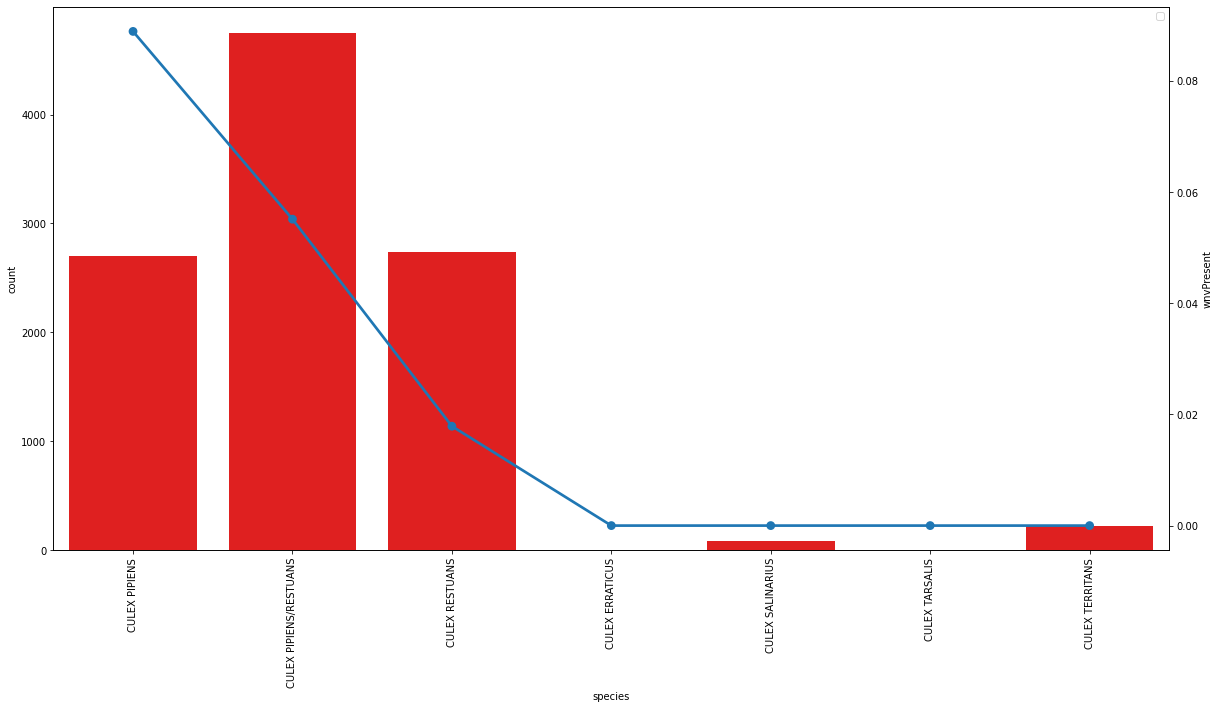

In [36]:
# Identifying Mosquito Species that are the most likely carriers of Virus.
tmp = pd.crosstab(train['species'],train['wnvpresent'],normalize='index')
tmp.reset_index(drop=True)
tmp.columns = ['wnvAbsent','wnvPresent']
fig,ax = plt.subplots(1,1, figsize = (20, 10))
g = sns.countplot(x = 'species', 
                  data = train,
                  ax=ax, 
                  order = tmp.sort_values(by = 'wnvPresent', ascending = False).index, 
                  color = 'red')
ax.tick_params(axis='x',rotation=90)
g2 = g.twinx()
sns.pointplot(x = tmp.index,
              y = 'wnvPresent', 
              data = tmp ,
              ax=g2, 
              order = tmp.sort_values(by = 'wnvPresent', ascending = False).index)

g2.set_label('adsa')
ax.legend();

In [25]:
# Drop duplicate
train.drop_duplicates(subset= ['species', 'trap', 'date'], inplace=True)

# Drop the columns created and rename the column
train.drop(columns = ['concat', 'nummosquitos_x'], errors='ignore', inplace=True)
train.rename(columns = {'nummosquitos_y':'total_mosquitos'},inplace=True)

# Checking
train.shape

(8475, 12)

### KMeans classifying of traps to weather stations

In [26]:
# KMeans for trap based on station

X = train[['latitude', 'longitude']]
centroid = np.array(object = ([41.995, -87.933], [41.786, -87.752]))  # creating the centroid
centroid

array([[ 41.995, -87.933],
       [ 41.786, -87.752]])

In [27]:
km = KMeans(n_clusters = 2,       # 2 stations so 2 clusters
            init = centroid, 
            tol= 0.01,            # adjust tolerance to better fit the line
            random_state = 42)

In [28]:
km.fit(X)

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[ 41.995, -87.933],
       [ 41.786, -87.752]]),
       n_clusters=2, random_state=42, tol=0.01)

In [29]:
station_preds = km.predict(X) + 1    # station 0/1, but we need 1/2 so +1

In [30]:
# add a new column
train['station'] = station_preds
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,wnvpresent,total_mosquitos,station
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,0,1,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,0,1,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,0,1,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,0,1,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,0,4,1


<span style = 'color:orange'>Remark:</span> This is to classify our traps so that we know which  traps are being affected by weathers predicted by which stations.

### Train_combine = train + weather data

In [31]:
train_combine = pd.merge(train,weather,on = ['date', 'station'], how = 'inner')
train_combine.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5


In [32]:
train_combine.shape

(8475, 33)

### Visualisation

In [33]:
# Create a visualized widget 

sliderx = IntSlider(min = 2, max = 4, description = 'DayofWeek')
slidery = IntSlider(min =2007, max = 2013, step = 2, description = 'Year')
sliderz = IntSlider(min = 0, max = 1, description = 'WnvPresent')
slideri = IntSlider(min = 5, max = 10, description = 'Month')

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt("datasets/mapdata_copyright_openstreetmap_contributors.txt")

intersection = [41.995, -87.933]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth
intersection2 = [41.786, -87.752]

def plot_func(x,y,z,i):
    
    
    plt.figure(figsize = (15,15))
    
    plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

    plt.scatter(x=intersection[1], y=intersection[0], c='b', s=60, marker='s')
    
    plt.scatter(x=intersection2[1], y=intersection2[0], c='b', s=60, marker='s')
    
    
    
    color = ['blue', 'red']
    plt.scatter(x='longitude',y='latitude',
                data = train_combine.loc[train_combine['wnvpresent'] == z]\
                .loc[train_combine['date'].dt.month == i]\
                .loc[train_combine['date'].dt.year == y],
                s=60,c = color[z])
    
    
    plt.scatter(x='longitude', y='latitude',
                data = spray.loc[spray['date'].dt.dayofweek == x ]\
                .loc[spray['date'].dt.month == i]\
                .loc[spray['date'].dt.year == y],
                c ='green', s=10, alpha = 0.2)
    
    sns.scatterplot(x='longitude',
                    y='latitude',
                    data = train_combine.loc[train_combine['station'] == 1].loc[train_combine['date'].dt.month == i]\
                    .loc[train_combine['date'].dt.year == y],
                    color = 'yellow',
                    marker = 'o',
                    s=20)
    
    sns.scatterplot(x='longitude',
                    y='latitude',
                    data = train_combine.loc[train_combine['station'] == 2].loc[train_combine['date'].dt.month == i]\
                    .loc[train_combine['date'].dt.year == y],
                    color = 'green',
                    marker = 'o',
                    s=20)
    plt.show()

interact(plot_func, x= sliderx, y = slidery, z = sliderz, i = slideri);

OSError: datasets/mapdata_copyright_openstreetmap_contributors.txt not found.

<span style = 'color:orange'>Remark:</span> We are observing the spatial relationship between traps, sprays & WNVpresent across time.

### Data Cleaning for train_combine

In [34]:
# Create a copy of thr train_combine for further data cleaning
train_clean = train_combine.copy()
for i in train_clean.columns:
        train_clean[i] = train_clean[i].replace("M", np.nan).replace("-", np.nan)

In [35]:
# Checking features that contains null values
train_clean.isnull().sum()[train_clean.isnull().sum() !=0]

depart         4696
wetbulb          48
sunrise        4696
sunset         4696
depth          4696
water1         8475
snowfall       4696
preciptotal      18
stnpressure      48
dtype: int64

In [36]:
print(train_clean['snowfall'][train_clean['station'] == 1].value_counts())
print('')
print(train_clean['depth'][train_clean['station'] == 1].value_counts())

0.0    3691
  T      88
Name: snowfall, dtype: int64

0    3779
Name: depth, dtype: int64


In [37]:
# based on data description, drop column unessacary data with majority of null
train_clean.drop(columns=['depart','water1','depth','snowfall','address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'],inplace=True, errors='ignore')

<span style = 'color:orange'>Remark:</span> We dropped 4 of these columns based on the following:
- Snowfall & depth contains 3779 0 values, inclusion of the 4696 null values making them insignificant to our problem statment 
- depart is a derivatives from tempature. We will use heat and cool to measure tempature instead
- Water1 is not avaialbe from both stations. 
- addrees and the related columns are dropped as we are using lat and long for spatial features

In [38]:
# function that change time to seconds
def changetime(x):
    try:
        x = str(int(x))
        x1 = int(x[0])*60*60
        x2 = int(x[1:])*60
        x = x1 + x2
        return x
    except:
        return x
    
train_clean['sunrise'] = train_clean['sunrise'].map(lambda x: changetime(x)) # make changes on sunrise 
train_clean['sunset'] = train_clean['sunset'].map(lambda x: changetime(x))    # make changes on sunset

In [39]:
# fillna for sunset/sunrise with mean
mean_sunset = (train_clean['sunset'].loc[train_clean['sunset'].notnull()].sum()/len(train_clean[train_clean['sunset'].notnull()]))
mean_sunrise = (train_clean['sunrise'].loc[train_clean['sunrise'].notnull()].sum()/len(train_clean[train_clean['sunrise'].notnull()]))

train_clean['sunrise'].fillna(round(mean_sunrise), inplace = True)
train_clean['sunset'].fillna(round(mean_sunset), inplace = True)

In [40]:
# make sunset - sunrise = nighttime
train_clean['nighttime'] = train_clean['sunset'] - train_clean['sunrise']
train_clean['nighttime'] = train_clean['nighttime'].map(lambda x: 24 - round(x/3600))  # round it to be only hour

In [41]:
train_clean['nighttime'].value_counts()

13    5181
12    1622
14     733
16     451
15     350
17     138
Name: nighttime, dtype: int64

In [42]:
train_clean[['sunset','sunrise','nighttime']].head()

,sunset,sunrise,nighttime
0,58620.0,15660.0,12
1,58620.0,15660.0,12
2,58620.0,15660.0,12
3,58620.0,15660.0,12
4,58620.0,15660.0,12


In [43]:
# after convert to nighttime, drop sunset and sunrise
train_clean.drop(columns=['sunrise','sunset'],inplace=True, errors='ignore')

In [44]:
# Check all the datatype
train_clean.dtypes

date               datetime64[ns]
species                    object
trap                       object
latitude                  float64
longitude                 float64
wnvpresent                  int64
total_mosquitos             int64
station                     int32
tmax                        int64
tmin                        int64
tavg                       object
dewpoint                    int64
wetbulb                    object
heat                       object
cool                       object
codesum                    object
preciptotal                object
stnpressure                object
sealevel                   object
resultspeed               float64
resultdir                   int64
avgspeed                   object
nighttime                   int64
dtype: object

In [45]:
# Change the data type from object to float
train_clean['stnpressure'] = train_clean['stnpressure'].astype('float')
train_clean['wetbulb'] = train_clean['wetbulb'].astype('float')
train_clean['cool'] = train_clean['cool'].astype('float')
train_clean['heat'] = train_clean['heat'].astype('float')
train_clean['tavg'] = train_clean['tavg'].astype('float')
train_clean['sealevel'] = train_clean['sealevel'].astype('float')
train_clean['avgspeed'] = train_clean['avgspeed'].astype('float')

In [46]:
# fillna for stnpressure with the average pressure of each station
mask1 = train_clean['station'] ==1
mask2 = train_clean['station'] ==2

# Find station 1 mean station pressure

sp1 = train_clean['stnpressure'][mask1].mean()
sp2 = train_clean['stnpressure'][mask2].mean()
train_clean['stnpressure'][train_clean['station']==1 & train_clean['stnpressure'].isnull()] = sp1
train_clean['stnpressure'][train_clean['station']==2 & train_clean['stnpressure'].isnull()] = sp2

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [47]:
# T = Trace, = 0.005 inches
# Change t to the correct value
train_clean.loc[train_clean['preciptotal'] == '  T','preciptotal'] = '0.005'
train_clean['preciptotal'] = train_clean['preciptotal'].astype(float)

# fillna with mean
precip_mean = train_clean['preciptotal'].mean()
train_clean.loc[train_clean['preciptotal'].isnull(),'preciptotal'] = precip_mean

In [48]:
# fillna with mean
wetbulb_mean = train_clean['wetbulb'].mean()
train_clean.loc[train_clean['wetbulb'].isnull(),'wetbulb'] = wetbulb_mean

# Change type to interger
train_clean['wetbulb'] = train_clean['wetbulb'].astype(int)

In [49]:
# Check if there are still any null values
train_clean.isnull().sum()[train_clean.isnull().sum() !=0]

Series([], dtype: int64)

### EDA using cleaned dataset

In [50]:
train_eda = train_clean.copy()

# make the date become datetime object and make it as the index
train_eda.set_index(pd.DatetimeIndex(train_eda['date']), inplace = True)
train_eda.drop(columns = ['date'], inplace = True)
train_eda.head()

,species,trap,latitude,longitude,wnvpresent,total_mosquitos,station,tmax,tmin,tavg,...,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,nighttime
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,1,1,88,60,74.0,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,0,1,1,88,60,74.0,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,0,1,1,88,60,74.0,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,1,1,88,60,74.0,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,0,4,1,88,60,74.0,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12


<span style = 'color:orange'>Remark:</span> Create a copy of our cleaned data sets for further EDA

In [51]:
# Function to plot line graph

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size.
    plt.figure(figsize=(15,3))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=8, rotation = 'vertical');

### Effect of weather and spray on wnvpresent
#### Weather data after standard scaler to have better view

In [52]:
train_eda_num = train_eda.select_dtypes(include=np.number)

In [53]:
# Set X as a dataframe in order to plot
train_eda_y = train_eda[['wnvpresent']]
train_eda_num.drop(columns=['wnvpresent'], inplace=True, errors='ignore')

# Scale our features columns
ss_eda = StandardScaler()
train_eda_num_ss = ss_eda.fit_transform(train_eda_num)

train_eda_num_df =pd.DataFrame(train_eda_num_ss, columns = train_eda_num.columns, index = train_eda_num.index)

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [54]:
train_eda_num_df.columns

Index(['latitude', 'longitude', 'total_mosquitos', 'station', 'tmax', 'tmin',
       'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'nighttime'],
      dtype='object')

In [55]:
interest_col = ['tmax', 'tmin','heat', 'cool', 'preciptotal','avgspeed','nighttime','wetbulb', 'resultspeed', 'stnpressure', 'sealevel',  'resultdir', 'total_mosquitos','dewpoint','tavg']

In [56]:
# train_eda_num_df_plot = train_eda_num_df.loc[train_eda_num_df.index.year == 2007].resample('2W-MON')[interest_col].mean()

# train_eda_y_plot = train_eda_y.loc[train_eda_y.index.year == 2007].resample('2W-MON')[['wnvpresent']].sum()

In [57]:
# train_eda_num_df_plot = train_eda_num_df.loc[train_eda_num_df.index.year == 2007].resample('2W-MON')[interest_col].agg('mean')
# train_eda_y_plot = train_eda_y.loc[train_eda_y.index.year == 2007].resample('2W-MON')[['wnvpresent']].sum()
# train_eda_num_df.head()

In [58]:
def combi_plot(df_x, df_y, x_col_ls, y_col, agg_ls, year_ls, resample_mode, fs_tuple):
    
    y_num = len(year_ls)
    
    fig = plt.figure(figsize=fs_tuple)
    spec = gridspec.GridSpec(nrows=y_num, ncols=1, figure=fig, hspace = 0.2)


    for item in range(y_num):
        
        ax1 = fig.add_subplot(spec[item,0])
        
        # Resample the dataframe
        df_a = df_x.loc[df_x.index.year == year_ls[item]].resample(resample_mode)[x_col_ls].agg(agg_ls[0])
        df_b = df_y.loc[df_y.index.year == year_ls[item]].resample(resample_mode)[[y_col]].agg(agg_ls[1])
        
        # Combine the dataframe
        combined_df = pd.concat([df_a, df_b], axis=1)

        #bar plot creation
        ax1.set_title(f'Features vs Wnvpresent in {year_ls[item]}', fontsize=16)
        ax1.set_xlabel('Date', fontsize=16)
        ax1.set_ylabel('Count', fontsize=16)
        sns.lineplot(x='date', y='wnvpresent', data=combined_df, palette='summer', linewidth=5, linestyle='--', label='wnvpresent', ax=ax1)
        ax1.tick_params(axis='y')
        ax1.get_legend().remove()

        #specify we want to share the same x-axis
        ax2 = ax1.twinx()
        

        #line plot creation
        ax2.set_ylabel('Feature scaled', fontsize=16)
        sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(combined_df.reset_index().drop(columns=y_col), ['date']),
                           palette='dark', style_order=interest_col, linewidth=2, ax=ax2)
        ax2.tick_params(axis='y', color='red')
        ax2.get_legend().remove()
        
        # Combine handles & labels from 2 subplots
        handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
        
    # additional manual adjustment to the figure    
    fig.legend(handles, labels, loc='upper right', prop={'size': 15})
    fig.suptitle('Plot of Features vs Wnvpresent by years', fontsize= 25)
    plt.subplots_adjust(top=0.95)

    plt.show()

ValueError: Could not interpret input 'date'

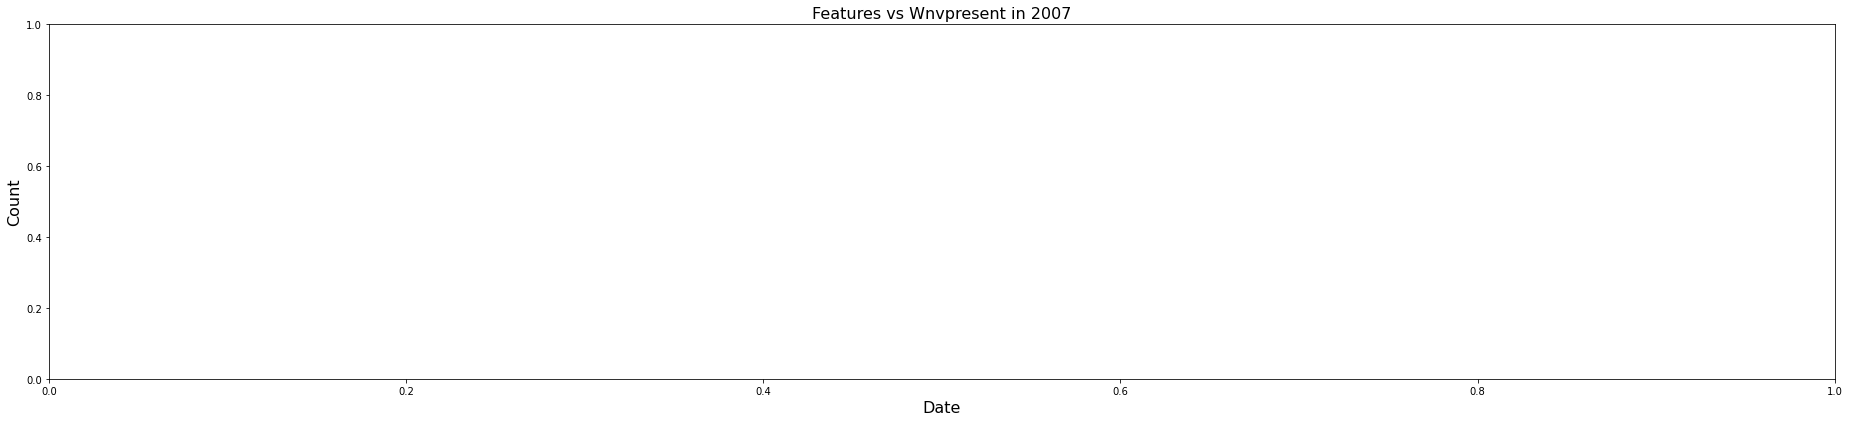

In [59]:
combi_plot(train_eda_num_df, train_eda_y, interest_col, 'wnvpresent', ['mean', 'sum'], [2007, 2009, 2011, 2013], '2W-MON', (32,30))

In [41]:
#combined_df.reset_index(inplace=True)

#combined_df[['wnvpresent']]

In [42]:
#combined_df['date'].astype(str)
#combined_df.head()

In [43]:
# spray['date'] = pd.to_datetime(spray['date'])
# spray.set_index('date', inplace=True)

In [ ]:
spray_plot = spray.loc[spray.index.year == 2011].resample('2W-MON')[['latitude']].count()

In [ ]:
# train_eda_num_df_plot.plot(y = interest_col[0:5], figsize = (15, 4));
# train_eda_y_plot.plot(y = 'wnvpresent', figsize = (15, 4));
# train_eda_num_df_plot.plot(y = interest_col[5:11], figsize = (15, 4));
# train_eda_y_plot.plot(y = 'wnvpresent', figsize = (15, 4));
# train_eda_num_df_plot.plot(y = interest_col[11:], figsize = (15, 4));
# train_eda_y_plot.plot(y = 'wnvpresent', figsize = (15, 4));
# spray_plot.plot(y = 'latitude', figsize = (15, 4)); 

#### Cant define whether spray brings any effect to reduce wnvpresent as wnvpresent more likely following weather trend

##### >>> delay reporting thats why wnvpresent later
##### >>> for better prediction, shift weather data

Researchers discovered that reports of human cases of West Nile virus in the United States were delayed by two to 14 weeks between illness onset and confirmation of West Nile. The lags were due to the length of time it took health departments to confirm a West Nile case or reporting delays between health care professionals and the health department. They also found that reporting of mosquitoes testing positive for the virus were also delayed, but by a much less significant amount of time.

(https://www.sciencedaily.com/releases/2019/04/190426110612.htm)

##### >>> temperature used, tmax as mosquitos cannot survive if temperature too high

West Nile virus spreads most efficiently in the US at temperatures between 24-25 degrees Celsius (75.2-77 degrees Fahrenheit).
The results suggest that climate change could lead to the increased spread of West Nile virus in some places, while potentially causing a decrease in others, and provide insight on where and when these changes might occur.

(https://www.sciencedaily.com/releases/2020/09/200915105932.htm)

### Pre-processing

In [ ]:
train_model = pd.read_csv('train_cleaned.csv')
train_model.head()

####  Codecum Multi-binarize (get dummies)

In [ ]:
# Splitting the string
for i in range(len(train_model['codesum'])):
    train_model['codesum'][i] = train_model['codesum'][i].split()

In [ ]:
train_model['codesum']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [ ]:
codesum_split = pd.DataFrame(mlb.fit_transform(train_model['codesum']),columns='codesum_' + mlb.classes_, index=train_model.index)

### one hot encoding for species

In [ ]:
# get dummies for species
train_model = pd.get_dummies(train_model, columns=['species'], dtype = 'int64')

In [ ]:
# merge back both dataframe
train_model = pd.concat([train_model, codesum_split], axis = 1, sort=False)
train_model.columns

In [ ]:
# Drop uneccesary columns
train_model.drop(columns=['address', 'block', 'street', 'trap',
                          'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy', 
                          'total_mosquitos', 'station','heat', 'codesum',
                          'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed'],inplace=True)
# Fillna 
train_model.fillna(value = 0, inplace = True)
train_model.info()

In [ ]:
train_model.to_csv('train_model.csv', index=False)

In [ ]:
# Set X and y
X = train_model.drop(columns=['wnvpresent'])
y = train_model['wnvpresent']

In [ ]:
# Set date to datetime object and set it as index
X['date'] = pd.to_datetime(X['date'])
X.set_index('date', inplace=True)

In [ ]:
# Set X as a dataframe in order to plot
ssplot = StandardScaler()
X_scaled = ssplot.fit_transform(X)
X_df =pd.DataFrame(X_scaled, columns = X.columns, index = X.index)

### >>> time shift for data

### Train test split

In [ ]:
# X = trainm.drop(columns=['wnvpresent'])
# y = trainm['wnvpresent']

In [ ]:
# X['date'] = pd.to_datetime(X['date'])
# X.set_index('date', inplace=True)

In [ ]:
# ssplot = StandardScaler()
# X_scaled = ssplot.fit_transform(X)
# df =pd.DataFrame(X_scaled, columns = X.columns, index = X.index)

In [ ]:
X.columns = X.columns.sort_values()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, stratify=y,test_size=0.2)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
# Function to run pipeline

def run_model(df,pipe_num,X_train,X_test,y_train,y_test):
    
    pipe_num.fit(X_train,y_train)
#     df['pred_probs'] = pipe_num.predict_proba(X_test)
    preds = pipe_num.predict(X_test)
    print("MCC score: ",matthews_corrcoef(y_test,preds))
    print("Accuracy score: ",pipe_num.score(X_test,y_test))
    plot_confusion_matrix(pipe_num,X_test,y_test)
    plot_roc_curve(pipe_num,X_test,y_test)
    

In [ ]:
# The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binary and multiclass classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. 
# The MCC is in essence a correlation coefficient value between -1 and +1. 
# A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. 
# The statistic is also known as the phi coefficient. [source: Wikipedia]

In [ ]:
pipe_1 = Pipeline([('ss', StandardScaler()),('sgd', SGDClassifier(max_iter = 1000, tol=0.001))])

In [ ]:
run_model(train_model,pipe_1,X_train,X_test,y_train,y_test)

In [ ]:
pipe_2 = Pipeline([('scale', StandardScaler()), ('sampling', SMOTE(k_neighbors=6)),
                   ('svc', SVC(C=1.0,kernel='poly',degree=3))])

# Smote to resample and svc for classification

In [ ]:
run_model(train_model,pipe_2,X_train,X_test,y_train,y_test)

In [ ]:
pipe_3 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=15)), ('RF', RandomForestClassifier(n_estimators=20) )])

In [ ]:
run_model(train_model,pipe_3,X_train,X_test,y_train,y_test)

In [ ]:
pipe_4 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=10)), 
                   ('xgb', XGBClassifier(n_estimators=200,learning_rate=0.3))])

In [ ]:
run_model(train_model,pipe_4,X_train,X_test,y_train,y_test)

### >>> GridSearch for best model

In [ ]:
pipe = Pipeline([('sampling', SMOTE(random_state=42)),('xgb', XGBClassifier())])
pipe.get_params()

In [ ]:
pipe_params = {'sampling__k_neighbors': [5,10,15,20], 'xgb__n_estimators': [50,100,150,200], 
               'xgb__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# ,'xgb__scale_pos_weight':[1,100]

In [ ]:
# def custom_auc(ground_truth, predictions):
#      # I need only one column of predictions["0" and "1"]. You can get an error here
#      # while trying to return both columns at once
#     fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
#     return auc(fpr, tpr)

# my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Instantiate GridSearchCV.
gs = GridSearchCV(pipe,param_grid = pipe_params,scoring = 'roc_auc', cv=5) 

# Fit GridSearch to clean_training data.
gs.fit(X_train,y_train)

In [ ]:
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
gs.cv_results_

In [ ]:
gs_model = gs.best_estimator_

In [ ]:
gs_model.score(X_train, y_train)

In [ ]:
preds = gs_model.predict(X_test)
print("MCC score: ",matthews_corrcoef(y_test,preds))
print("Accuracy score: ",gs_model.score(X_test,y_test))
plot_confusion_matrix(gs_model,X_test,y_test);
plot_roc_curve(gs_model,X_test,y_test);

### >>> Cost benefit

chemical used for spraying -- cost price of chemical used -- calculate by square feet

### >>>Test data cleaning and feature engineering

In [ ]:
# Test data
test = pd.read_csv('test.csv')
test.columns = test.columns.str.lower()    # Convert all heading to lower
test['date'] = pd.to_datetime(test['date'])    # Convert date to datetime
test.info()

### KMeans based on station in order to merge the weather
##### Test

In [ ]:
# KMeans for trap based on station

Xt = test[['latitude', 'longitude']]
centroid = np.array(object = ([41.995, -87.933], [41.786, -87.752]))  # creating the centroid
centroid

In [ ]:
km = KMeans(n_clusters = 2,       # 2 stations so 2 clusters
            init = centroid, 
            tol= 0.01,            # adjust tolerance to better fit the line
            random_state = 42)

In [ ]:
km.fit(Xt)

In [ ]:
station_preds = km.predict(Xt) + 1    # station 0/1, but we need 1/2 so +1

In [ ]:
# add a new column
test['station'] = station_preds
test['station'].value_counts()

In [ ]:
test_combine = pd.merge(test,weather,on = ['date', 'station'], how = 'inner')
test_combine.head()

In [ ]:
test_combine.to_csv('test_combine.csv', index=False)

In [ ]:
# test_combine['stnpressure'].value_counts()

### Data Cleaning and Feature engineering
#### Test

In [38]:
# Read in dataset with M as null values as per data description for weather dataset
test_clean = pd.read_csv('test.csv', na_values = ['M', '-'])

In [ ]:
# Drop the columns
# based on data description, drop column unessacary data with majority of null
test_clean.drop(columns=['depart','water1','depth','snowfall'],inplace=True)

In [41]:
test_clean.shape, train.shape

((116293, 11), (10506, 12))

In [ ]:
test_clean.isnull().sum()

In [ ]:
# function that change time to seconds
def changetime(x):
    try:
        x = str(int(x))
        x1 = int(x[0])*60*60
        x2 = int(x[1:])*60
        x = x1 + x2
        return x
    except:
        return x
    
test_clean['sunrise'] = test_clean['sunrise'].map(lambda x: changetime(x)) # make changes on sunrise 
test_clean['sunset'] = test_clean['sunset'].map(lambda x: changetime(x))    # make changes on sunset

In [ ]:
# fillna for sunset/sunrise with mean
mean_sunset = (test_clean['sunset'].loc[test_clean['sunset'].notnull()].sum()/len(test_clean[test_clean['sunset'].notnull()]))
mean_sunrise = (test_clean['sunrise'].loc[test_clean['sunrise'].notnull()].sum()/len(test_clean[test_clean['sunrise'].notnull()]))

test_clean['sunrise'].fillna(round(mean_sunrise), inplace = True)
test_clean['sunset'].fillna(round(mean_sunset), inplace = True)

In [ ]:
# make sunset - sunrise = nighttime
test_clean['nighttime'] = test_clean['sunset'] - test_clean['sunrise']
test_clean['nighttime'] = test_clean['nighttime'].map(lambda x: round(x/3600))  # round it to be only hour

In [ ]:
test_clean['nighttime'].value_counts()

In [ ]:
test_clean[['sunset','sunrise','nighttime']]

In [ ]:
# after convert to nighttime, drop sunset and sunrise
test_clean.drop(columns=['sunrise','sunset'],inplace=True)

In [ ]:
# # fillna for stnpressure with the average pressure of each station
# mask1 = test_clean['station'] ==1
# mask2 = test_clean['station'] ==2

# # Find station 1 mean station pressure

# sp1 = test_clean['stnpressure'][mask1].mean()
# sp2 = test_clean['stnpressure'][mask2].mean()
# test_clean['stnpressure'][test_clean['station']==1 & test_clean['stnpressure'].isnull()] = sp1
# test_clean['stnpressure'][test_clean['station']==2 & test_clean['stnpressure'].isnull()] = sp2

In [ ]:
test_clean['stnpressure'].value_counts()

In [ ]:
test_clean['preciptotal'].value_counts()

In [ ]:
# T = Trace, = 0.005 inches
# Change t to the correct value
test_clean.loc[test_clean['preciptotal'] == '  T','preciptotal'] = '0.005'
test_clean['preciptotal'] = test_clean['preciptotal'].astype(float)

# fillna with mean
precip_mean = test_clean['preciptotal'].mean()
test_clean.loc[test_clean['preciptotal'].isnull(),'preciptotal'] = precip_mean

In [ ]:
test_clean['preciptotal'].value_counts()

In [ ]:
test_clean['wetbulb'].value_counts()

In [ ]:
# # fillna with mean
# wetbulb_mean = test_clean['wetbulb'].mean()
# test_clean.loc[test_clean['wetbulb'].isnull(),'wetbulb'] = wetbulb_mean

# # Change type to interger
# test_clean['wetbulb'] = test_clean['wetbulb'].astype(int)

In [ ]:
test_clean.info()

In [ ]:
# change date to datetime
test_clean['date'] = pd.to_datetime(test_clean['date'])

####  Codecum Multi-binarize (get dummies)
##### Test

In [ ]:
# Splitting the string
for i in range(len(test_clean['codesum'])):
    test_clean['codesum'][i] = test_clean['codesum'][i].split()

In [ ]:
test_clean['codesum']

In [ ]:
codesum_split = pd.DataFrame(mlb.fit_transform(test_clean['codesum']),columns='codesum_' + mlb.classes_, index=test_clean.index)

In [ ]:
# get dummies for species
test_clean = pd.get_dummies(test_clean, columns=['species'], dtype = 'int64')

In [ ]:
# merge back both dataframe
test_clean = pd.concat([test_clean, codesum_split], axis = 1, sort=False)
test_clean.columns

In [ ]:
train_model.columns

In [ ]:
test_clean = test_clean.rename(columns={'codesum_FG+': 'codesum_FG'})
test_clean.columns

In [ ]:
# Drop uneccesary columns
test_clean.drop(columns=['address', 'block', 'street', 'trap','addressnumberandstreet','latitude', 'longitude',
                         'addressaccuracy','station','heat', 'codesum','stnpressure', 'sealevel', 'resultspeed',
                         'resultdir', 'avgspeed','species_UNSPECIFIED CULEX','codesum_BCFG'],inplace=True)
# Fillna 
test_clean.fillna(value = 0, inplace = True)
test_clean.info()

In [ ]:
train_model.shape

In [ ]:
test_clean.shape

In [ ]:
test_clean.to_csv('test_final.csv', index=False)

In [ ]:
X_train.shape

In [ ]:
X_predict = test_clean.drop(columns=['id'])
X_predict['date'] = pd.to_datetime(X_predict['date'])
X_predict.set_index('date', inplace=True)
X_predict.shape

In [ ]:
X_predict.columns = X_predict.columns.sort_values()

In [ ]:
pipe_4.fit(X_train,y_train)
#     df['pred_probs'] = pipe_num.predict_proba(X_test)

In [ ]:
preds = pipe_4.predict(X_predict)
preds

In [ ]:
testing_submission = pd.DataFrame({'Id': test_clean['id'],'wnvpresent':preds})
testing_submission.head()

In [ ]:
testing_submission.to_csv('testing_submission.csv', index=False)

### Trying with the gridsearch model

In [ ]:
gs_model.fit(X_train,y_train)

In [ ]:
preds_gs = gs_model.predict(X_predict)
preds_gs

In [ ]:
gstesting_submission = pd.DataFrame({'Id': test_clean['id'],'wnvpresent':preds_gs})
gstesting_submission.head()

In [ ]:
gstesting_submission.to_csv('gstesting_submission.csv', index=False)